# Toy

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns
import math

import collections

# import latenta_manuscript as lam
import latenta as la
la.logger.setLevel("INFO")

## Transformation of a circular variable

To model a circular variable, we can either directly work in circular space, or in cartesian space.

In [132]:
n_samples = 30
sample_ids = [str(i) for i in range(n_samples)]
sample_index = pd.Series(sample_ids, name = "cell")

angle_value = pd.Series(np.linspace(0., (2. * np.pi), n_samples) % (math.tau), index = sample_index)
angle_value.name = "x"
angle_value.index.name = "cell"
angle = la.Fixed(angle_value, distribution = la.distributions.CircularUniform(), label = "circular")
angle

circular:  ↦ Fixed [cell (30)]

In [133]:
cartesian = la.transforms.Cartesian(angle, label = "cartesian")
cartesian

cartesian: x ↦ Cartesian [cell (30), axis (2)] = $\left[ cos(\text{circular})\;\;sin(\text{circular}) \right]\require{action}$

In [134]:
angle2 = la.transforms.Circular(cartesian, label = "circular2")
angle2

circular2: x ↦ Circular [cell (30)] = $\text{atan2}(\text{cartesian})\require{action}$

In [135]:
assert torch.allclose(angle.prior(), angle2.prior())


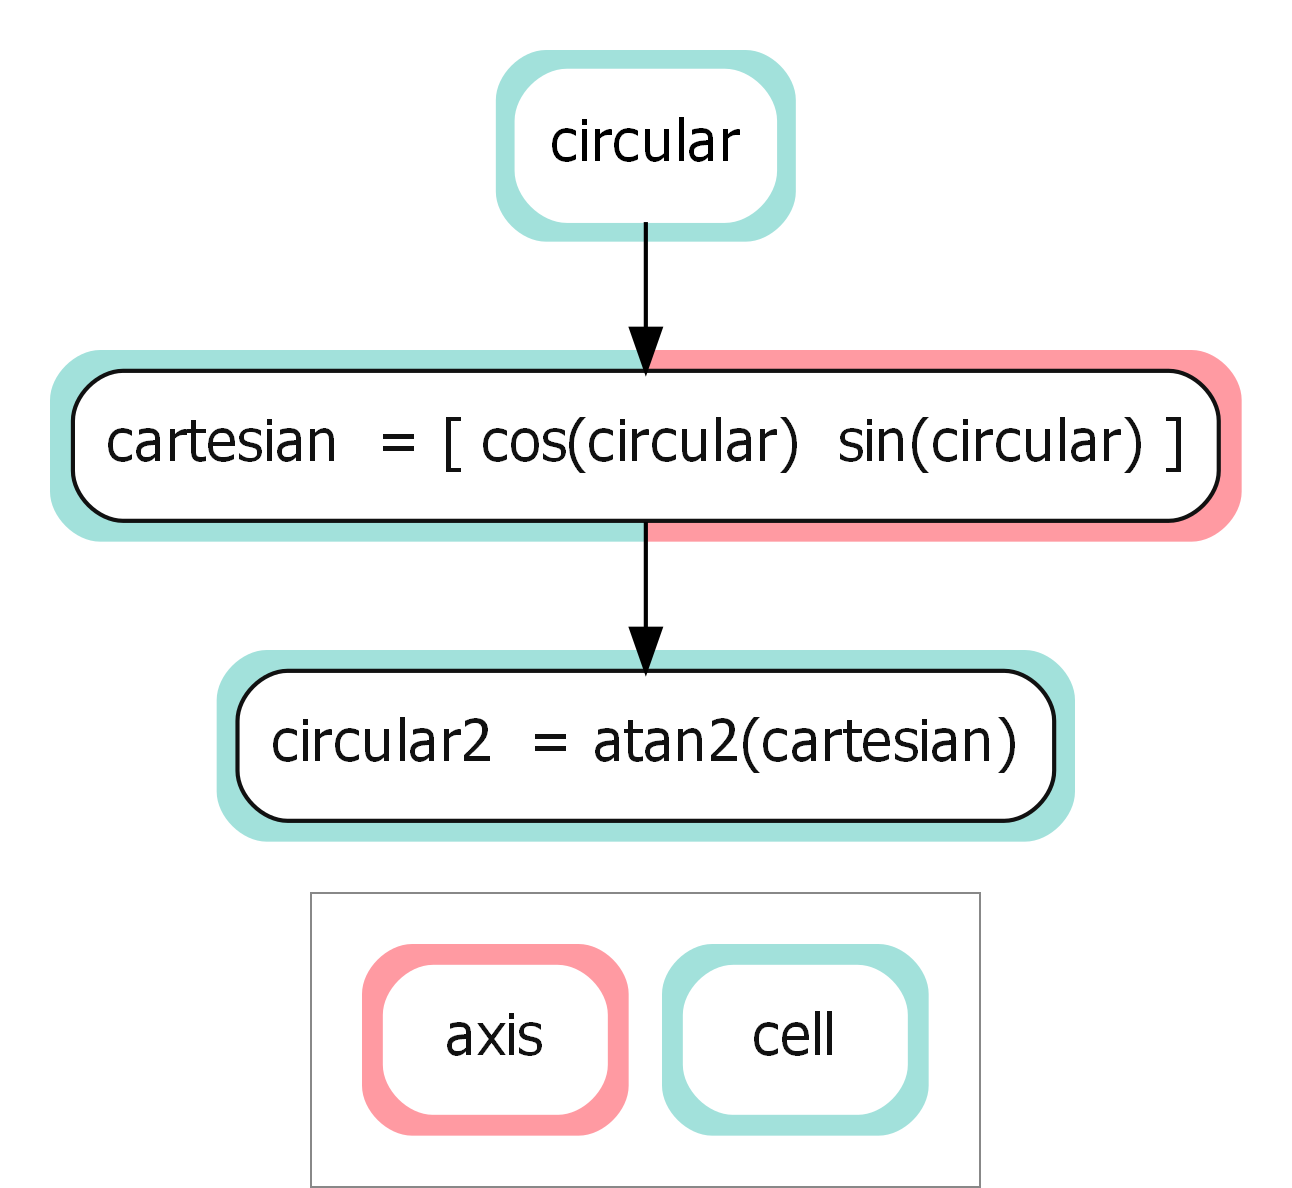

In [136]:
la.interpretation.ComponentGraph(angle2).display_graphviz()

## Generating data from a circular variable

In [137]:
n_features = 100
feature_ids = [str(i) for i in range(n_features)]
feature_index = pd.Series(feature_ids, name = "feature")

beta = la.Fixed(pd.Series(np.random.uniform(-3, 3, n_features), index = feature_index), label = "beta")
shift = la.Fixed(pd.Series(np.random.uniform(0., np.pi, n_features), index = feature_index), label = "shift")
# scale = la.Fixed(pd.Series(np.random.uniform(0.1, 0.3, n_features), index = feature_index), label = "scale")
scale = la.Fixed(pd.Series(np.random.uniform(1., 2., n_features), index = feature_index), label = "scale")

[autoreload of latenta.model.scalar_to_vector failed: Traceback (most recent call last):
  File "c:\users\woute\miniconda3\appdata\local\miniconda\envs\latenta\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\woute\miniconda3\appdata\local\miniconda\envs\latenta\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\users\woute\miniconda3\appdata\local\miniconda\envs\latenta\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\users\woute\miniconda3\appdata\local\miniconda\envs\latenta\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>",

In [139]:
import math

In [141]:
x = np.array([1, 2, 3, 4])
y = np.array([1, 2, 3, 4])

In [9]:
y = la.model.scalar_to_vector.Sine(angle, beta,shift = shift)

In [10]:
dist = la.distributions.Normal(loc = y, scale = scale)


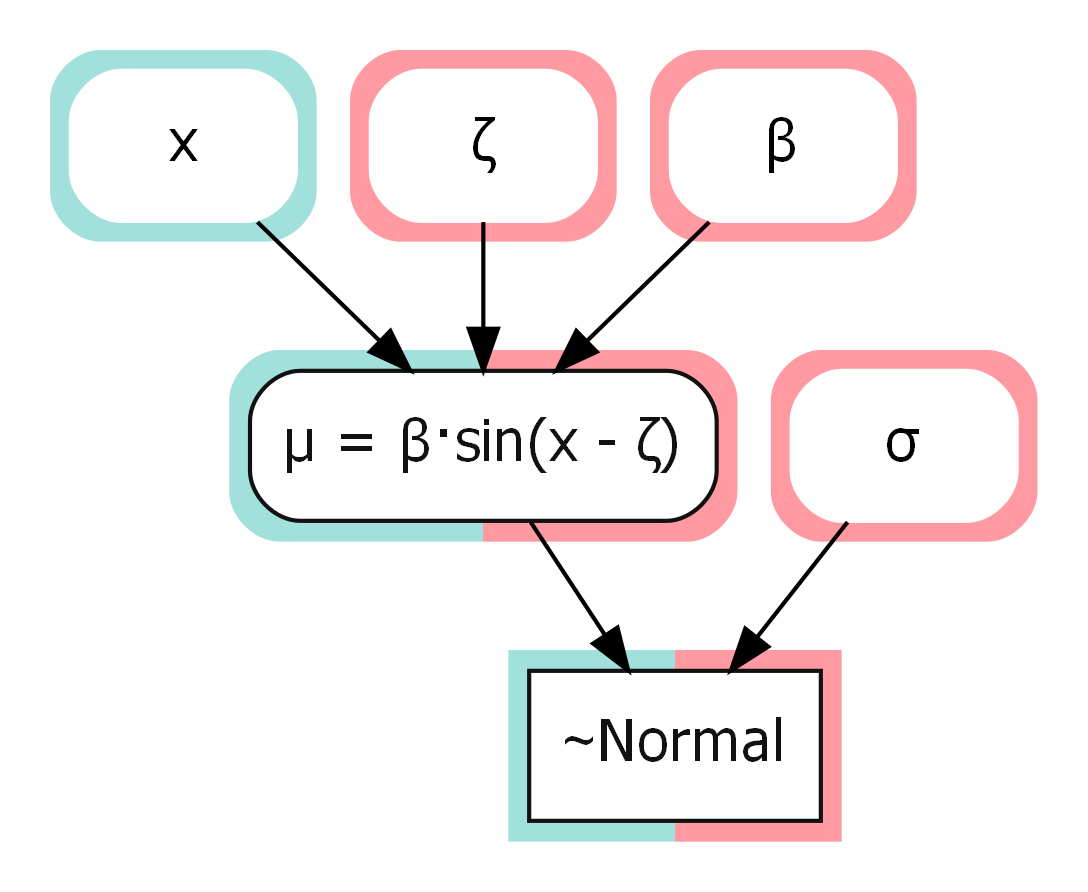

In [11]:
la.interpretation.ComponentGraph(dist).display_graphviz(legend = False)

<AxesSubplot:>

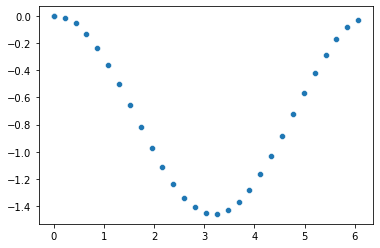

In [12]:
sns.scatterplot(x = angle.prior().numpy(), y = y.prior()[:, 0].numpy())

In [13]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

<AxesSubplot:xlabel='feature', ylabel='cell'>

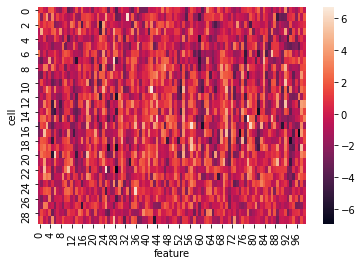

In [14]:
observed_value = posterior.samples[dist].sel(sample = 0).to_pandas()
sns.heatmap(observed_value)

## Bayesian modelling


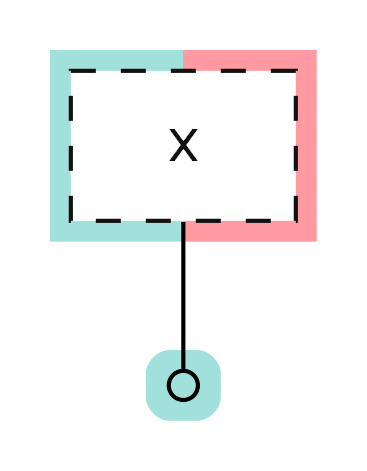


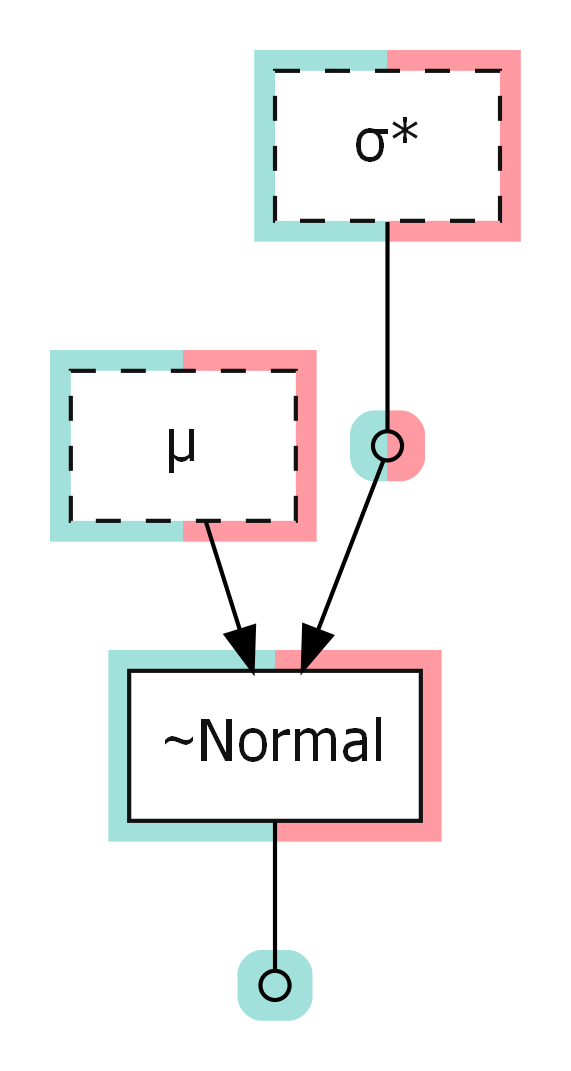

In [65]:
variational = angle.biject_to()

graph = la.interpretation.ComponentGraph(variational)
graph.display_graphviz(legend = False)

variational = la.distributions.Normal.from_parameter(variational)

graph = la.interpretation.ComponentGraph(variational)
graph.display_graphviz(legend = False)

In [66]:
a_dist = la.distributions.CircularUniform()

a = la.Latent(
    a_dist,
    angle,
    initial = angle.prior_xr()
)
# a = x


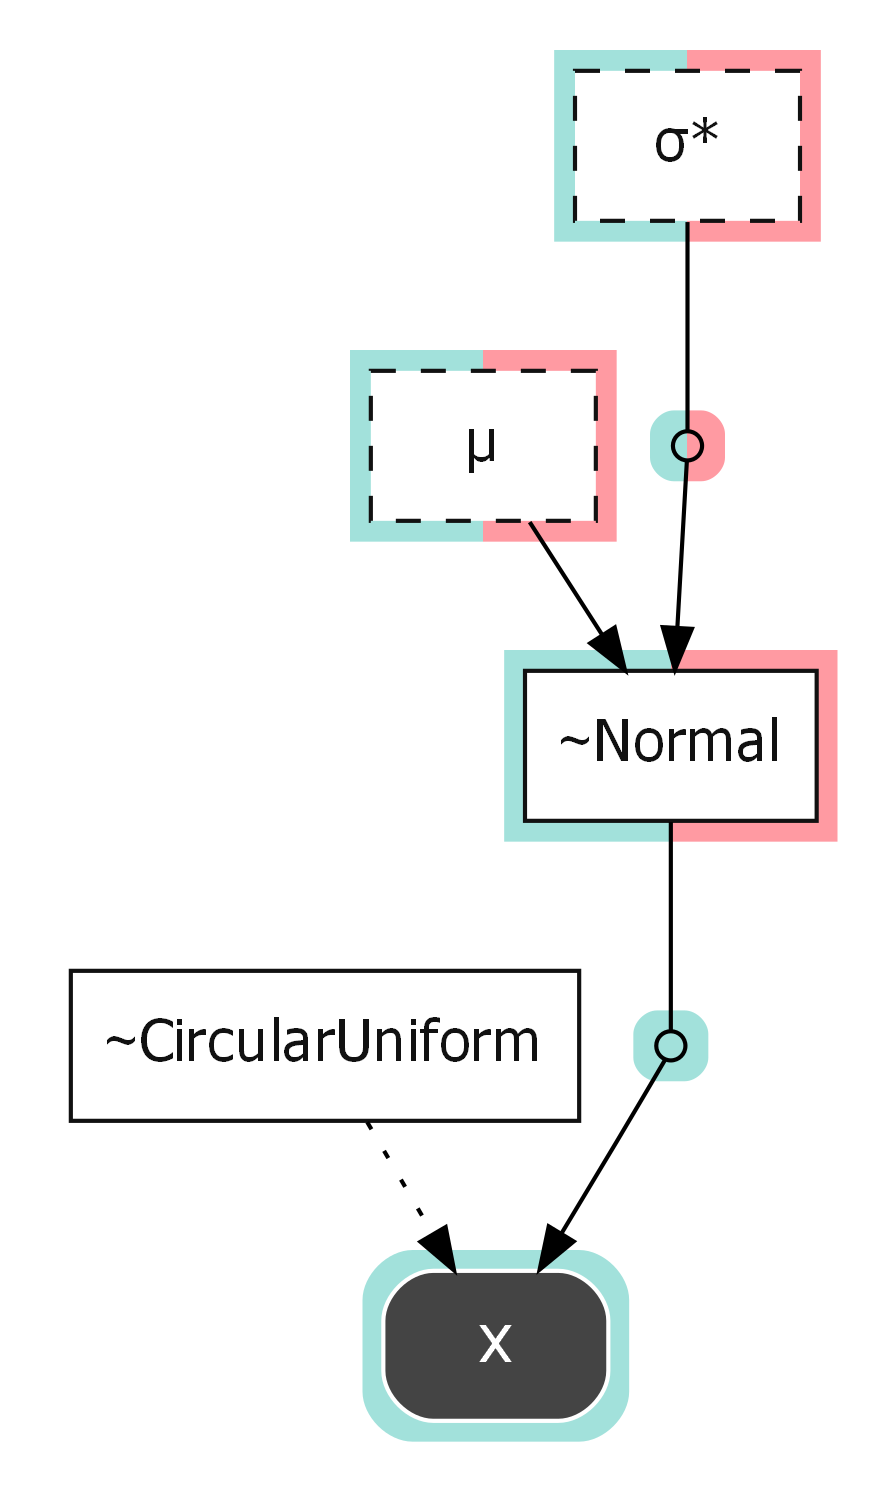

In [67]:
graph = la.interpretation.ComponentGraph(a)
graph.display_graphviz(legend = False)

In [156]:
output_definition = la.Definition.from_xr(observed_value)
output_definition

In [149]:
h_dist = 
# h_dist = la.distributions.Normal(definition = shift)

# h = shift

In [150]:
s_dist = la.distributions.LogNormal(1., 0.5)
s = la.Latent(s_dist, la.Definition(), label = "scale")

In [167]:
z = la.model.scalar_to_vector.Sine(
    a, 
    b = la.Latent(la.distributions.Normal(), beta),
    shift = la.Latent(la.distributions.CircularUniform(), shift),
    output = output_definition,
    c = True
)#b, shift = h, c = True)

In [168]:
dist2 = la.distributions.Normal(loc = z, scale = s)

observed = la.Observed(observed_value, dist2, label = "observed")


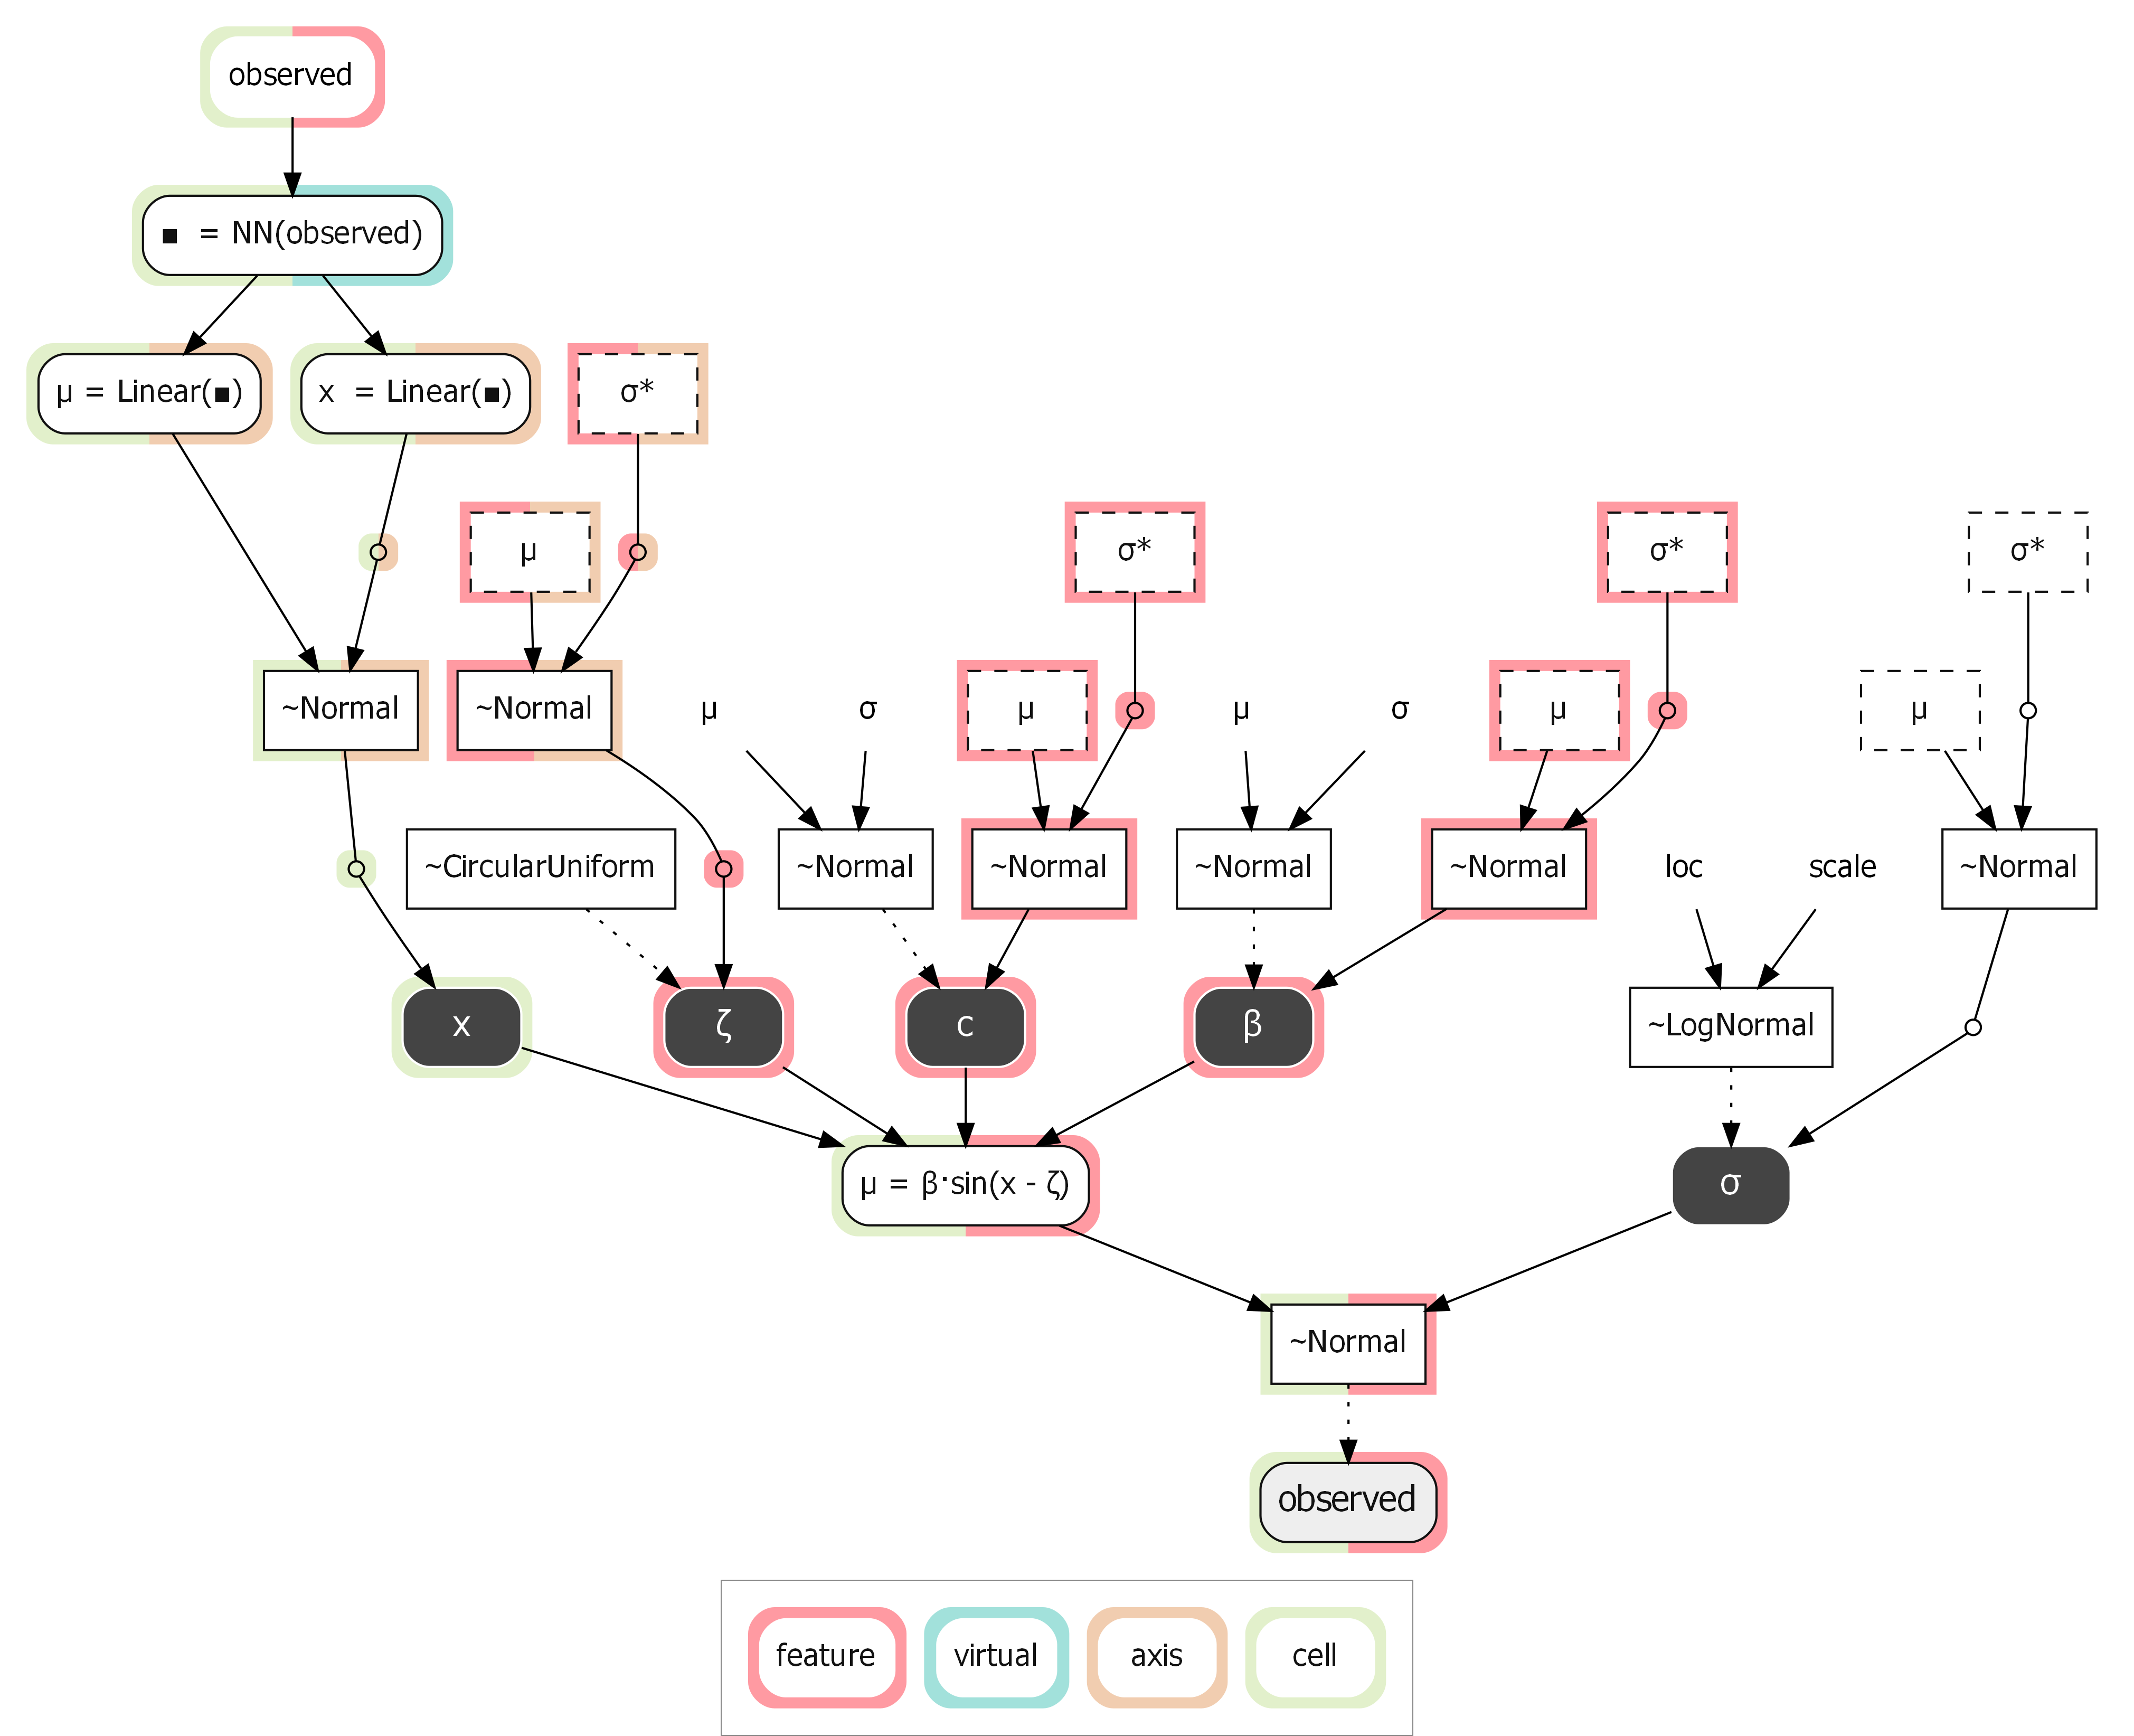

In [169]:
graph = la.interpretation.ComponentGraph(la.Model(observed)).display_graphviz(legend = True)

In [170]:
model = la.Model(observed)

In [171]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01))
trainer = la.infer.trainer.Trainer(inference)

In [172]:
trace = trainer.train(10000)

In [173]:
posterior = la.posterior.Posterior(observed)
posterior.sample(1)

<AxesSubplot:xlabel='feature', ylabel='cell'>

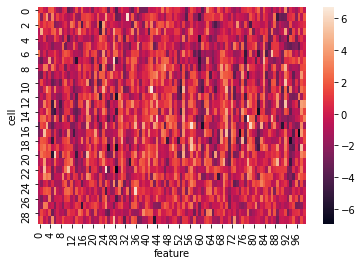

In [174]:
sns.heatmap(observed_value)

<AxesSubplot:xlabel='feature', ylabel='cell'>

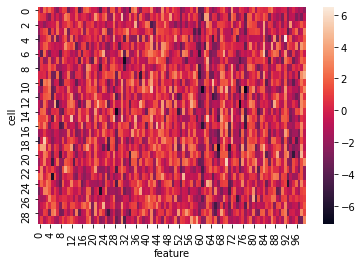

In [176]:
modelled_value = posterior.samples[dist2].sel(sample = 0).to_pandas()
sns.heatmap(modelled_value)

<AxesSubplot:ylabel='x'>

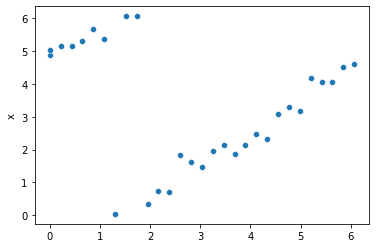

In [177]:
sns.scatterplot(
    x = angle.tensor_to_xr(angle.prior()).to_pandas(),
    y = posterior.samples[a].mean("sample")
)

<AxesSubplot:ylabel='beta'>

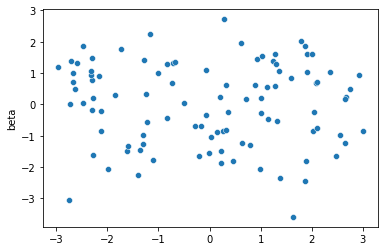

In [184]:
sns.scatterplot(
    x = beta.tensor_to_xr(beta.prior()).to_pandas(),
    y = posterior.samples[z.b].mean("sample")
)

In [185]:
z.empirical = xr.DataArray(observed_value)

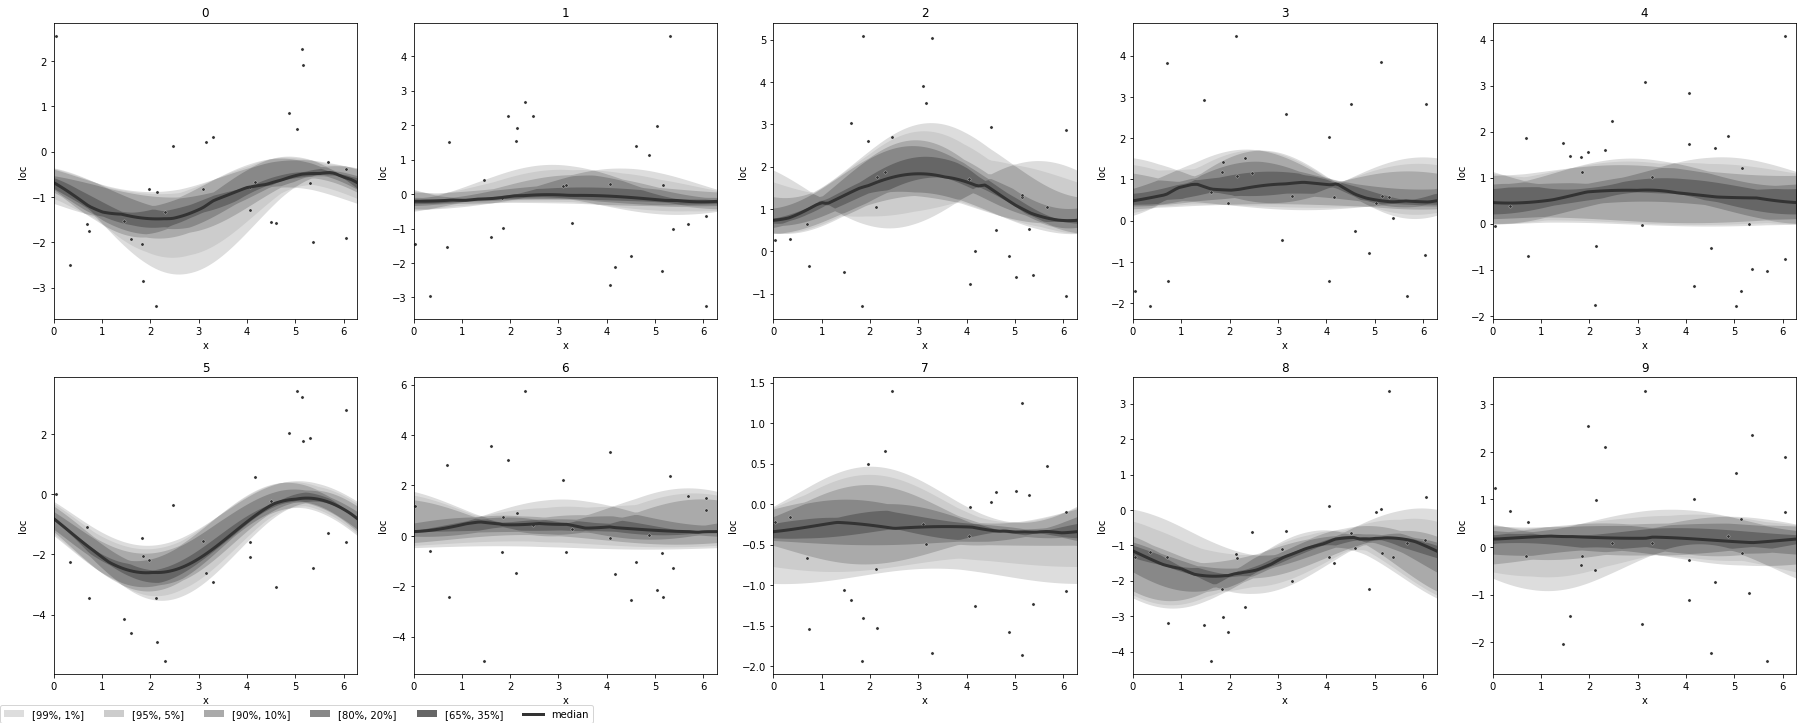

In [187]:
causal = la.posterior.ScalarVectorCausal(a, observed, observed = posterior)
causal.sample(10)
causal.plot_features();

## Amortization

In [188]:
old_loc = a.variational.x.loc
old_scale = a.variational.x.scale.x

In [189]:
inpu = la.Fixed(observed_value, label = "observed")

In [190]:
n_cells = inpu.shape[0]

In [191]:
from latenta.transforms import Transform

In [192]:
nn = torch.nn.Sequential(
    torch.nn.Linear(inpu.shape[1],25),
    torch.nn.ReLU()
)
seq = la.nn.NN(inpu, nn, output = la.Definition(dims = [a.dims[0], "virtual"], shape = [None, 25]), label = "■")

seq_loc = la.nn.Linear(seq, old_loc.broadcast(old_loc.dims[0]))
seq_scale = la.nn.Linear(seq, old_scale.broadcast(old_loc.dims[0]))

In [193]:
a.variational.x.loc = seq_loc
a.variational.x.scale.x = seq_scale

In [194]:
model2 = la.Model(observed)


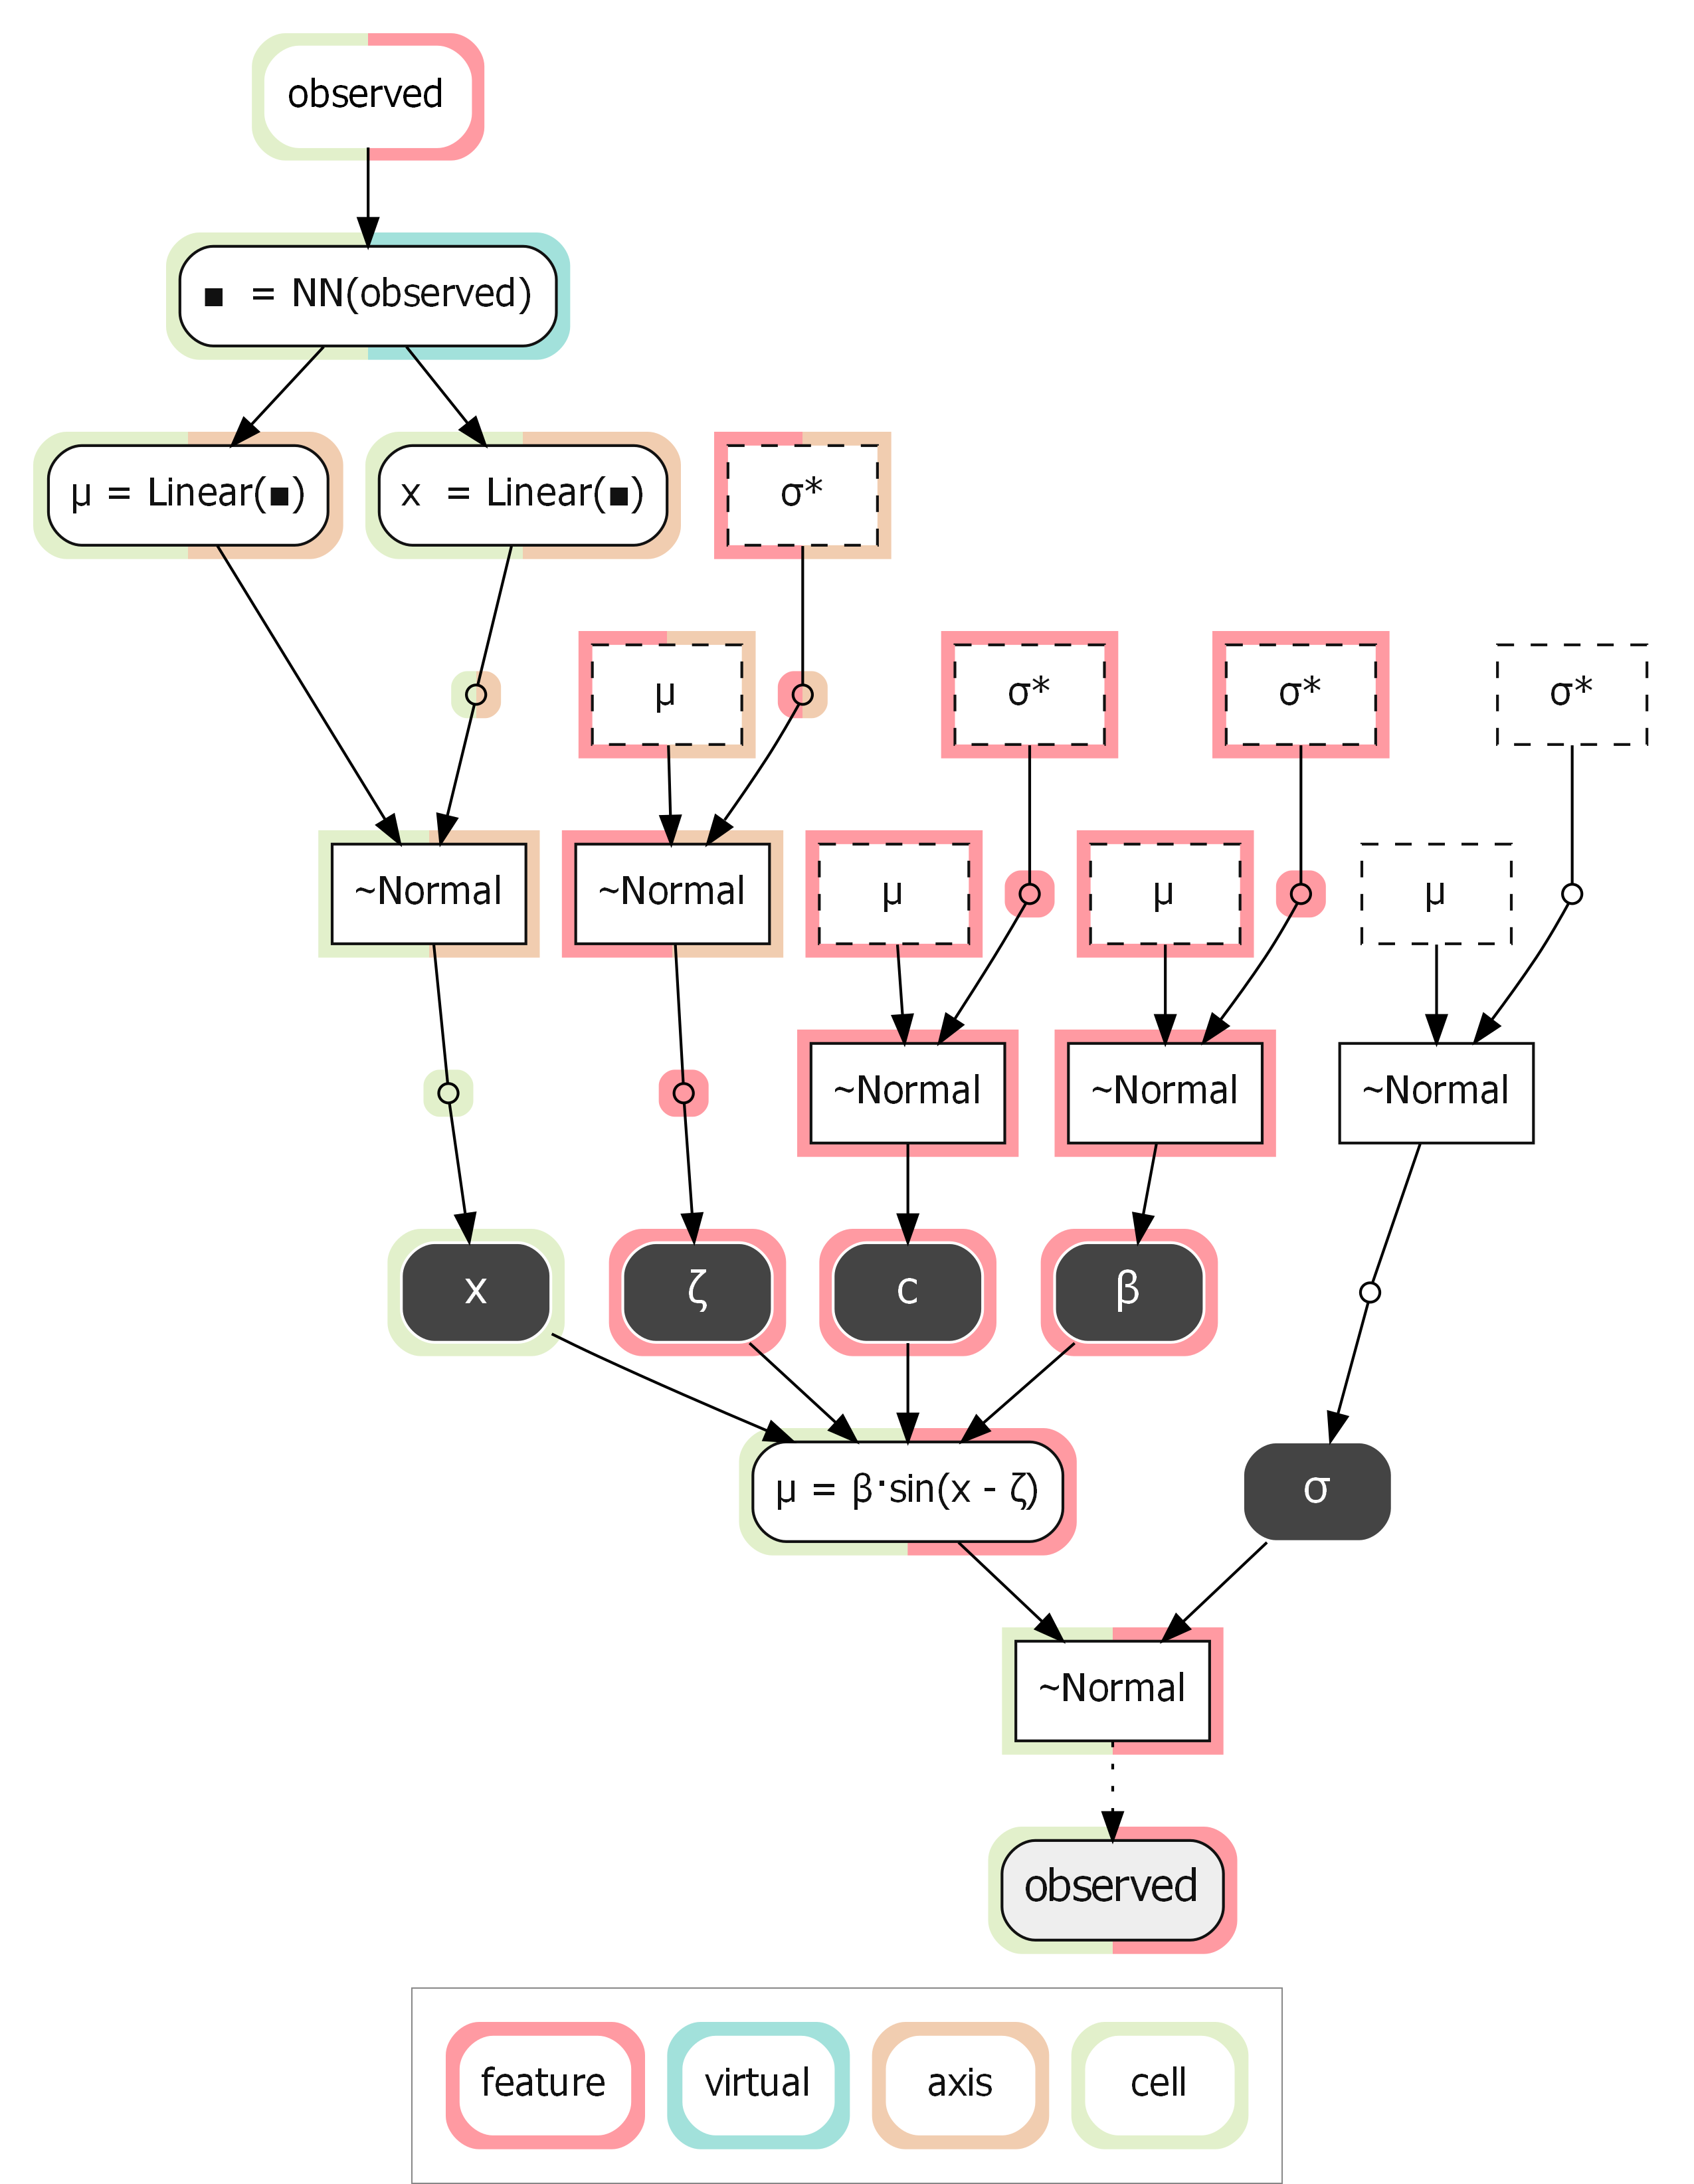

In [195]:
la.interpretation.filter(model2, variational = False)
la.interpretation.ComponentGraph(model2).display_graphviz()

In [196]:
model = la.Model(observed)

In [197]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01))
trainer = la.infer.trainer.Trainer(inference)

In [198]:
trace = trainer.train(10000)

In [199]:
posterior = la.posterior.Posterior(observed)
posterior.sample(1)

<AxesSubplot:ylabel='x'>

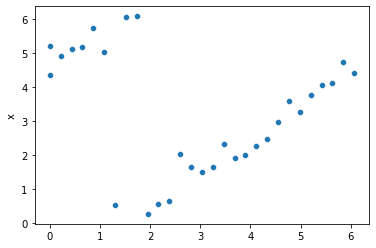

In [200]:
sns.scatterplot(
    x = angle.tensor_to_xr(angle.prior()).to_pandas(),
    y = posterior.samples[a].mean("sample")
)